# Train SetFit model

In [ ]:
%pip install git+https://github.com/huggingface/setfit.git
%pip install onnx==1.15.0
%pip install onnxruntime==1.16.1
%pip install netcal==1.3.5

## Import packages and fix random seed

In [ ]:
import setfit
from setfit import SetFitHead, SetFitHead, SetFitModel
from sentence_transformers import SentenceTransformer
import onnxruntime
from transformers import AutoTokenizer
from setfit.exporters.onnx import export_onnx
import torch
from torch.nn.functional import softmax
import numpy as np

In [ ]:
# Set glabaly random seed
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

# Define Dataset

*Note If use this notebook in Google Colab please upload all the data and indicate the path.*

In [ ]:
import os
import pandas as pd

data_dir = "./"

df_train = pd.read_csv(os.path.join(data_dir, "train_transformed.csv"))
df_val = pd.read_csv(os.path.join(data_dir, "val_transformed.csv"))
df_test = pd.read_csv(os.path.join(data_dir, "test_transformed.csv"))


In [ ]:
import pandas as pd
from datasets import load_dataset
dataset = load_dataset(
    "csv",
    data_files={
        "train": [os.path.join(data_dir, "train_transformed.csv")],
        "val": [os.path.join(data_dir, "val_transformed.csv")],
        "test": [os.path.join(data_dir, "test_transformed.csv")],
    },
    delimiter=',',
)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

## Learn embeddings in Siamese fashing using Triplet loss

In [ ]:
from sentence_transformers.losses import CosineSimilarityLoss, BatchAllTripletLoss
from setfit import SetFitModel, SetFitTrainer, sample_dataset


num_classes = len(df_train.label.unique())

# Simulate the few-shot regime by sampling num_samples examples per class
train_dataset = sample_dataset(dataset["train"], label_column="label_id", num_samples=1000)

base_model_name = "sentence-transformers/all-MiniLM-L12-v2"
tuned_model_path = os.path.join("models", "all-MiniLM-L12-v2-tuned-v2")
model = SetFitModel.from_pretrained(
    base_model_name,
    use_differentiable_head=True,
    head_params={"out_features": num_classes},
)


# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=dataset["val"],
    loss_class=BatchAllTripletLoss,
    metric="accuracy",
    learning_rate=1e-5,
    batch_size=32,
    num_iterations=5, # The number of text pairs to generate for contrastive learning
    num_epochs=5, # The number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label_id": "label"}, # Map dataset columns to text/label expected by trainer, key is from dataset columns
)

# Train and evaluate
trainer.freeze() # Freeze the head
trainer.train() # Train only the body

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 1992
  Num epochs = 5
  Total optimization steps = 310
  Total train batch size = 32


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

Iteration:   0%|          | 0/62 [00:00<?, ?it/s]

## Fine-tune classification head with frozen encoder

In [ ]:
trainer.unfreeze(keep_body_frozen=True)
# or
# Unfreeze the head and unfreeze the body -> end-to-end training
# trainer.unfreeze(keep_body_frozen=False)
#
trainer.train(
    num_epochs=5, # The number of epochs to train the head or the whole model (body and head)
    batch_size=16,
    body_learning_rate=1e-5, # The body's learning rate
    learning_rate=1e-1, # The head's learning rate
    l2_weight=0.001, # Weight decay on **both** the body and head
)
metrics = trainer.evaluate()
print(metrics)

Applying column mapping to training dataset
The `max_length` is `None`. Using the maximum acceptable length according to the current model body: 128.


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


{'accuracy': 0.9753483386923901}


## Save Pytorch and ONNX models

In [ ]:
# Save pytorch model
model._save_pretrained(tuned_model_path)

In [ ]:
# Save id to label mapping
import json

id2label_path = os.path.join(tuned_model_path, "id2label.json")
with open(id2label_path, "w") as fp:
  id2labels_dict = dict(df_train[["label_id", "label"]].values)
  json.dump(id2labels_dict, fp)

id2labels_dict

{0: 'flight',
 1: 'airfare',
 2: 'ground_service',
 3: 'quantity',
 4: 'airline',
 5: 'flight_time',
 6: 'abbreviation',
 7: 'day_name',
 8: 'aircraft',
 9: 'city',
 10: 'distance',
 11: 'ground_fare',
 12: 'airline+flight_no',
 13: 'airport',
 14: 'cheapest',
 15: 'restriction',
 16: 'capacity',
 17: 'ground_service+ground_fare',
 18: 'meal',
 19: 'airfare+flight_time',
 20: 'aircraft+flight+flight_no',
 21: 'flight+airfare',
 22: 'flight+airline',
 23: 'flight_no'}

In [ ]:
# Export ONNX model
onnx_model_path = os.path.join(tuned_model_path, "model.onnx")
model.model_body.eval()
model.model_head.eval()
export_onnx(model.model_body,
            model.model_head,
            opset=12,
            output_path=onnx_model_path)

### Check if ONNX model works fine

In [ ]:
# Test if ONNX model works
import onnxruntime as ort
import numpy as np

# Load the ONNX model
session = ort.InferenceSession(onnx_model_path)

In [ ]:
# Tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(tuned_model_path)

# Generate dummy inputs
dummy = dict(tokenizer(["show me the all flights from chicago today"], return_tensors="np"))

# Run single inference
output_names = [output.name for output in session.get_outputs()]
output = session.run(output_names, dummy)
output[0]

array([[ 71.67281  , -44.721004 , -40.8275   , -10.967424 ,  17.612537 ,
         -5.634858 , -46.365047 , -25.15323  ,  -5.334244 , -52.647675 ,
        -23.090025 , -73.49075  , -51.52553  ,  -7.2155094, -24.38998  ,
        -13.65117  , -59.292583 , -57.67721  , -46.338757 , -52.606716 ,
        -42.21004  ,  14.854507 ,   7.0908732, -57.07135  ]],
      dtype=float32)

## Run evaluation on Test set using ONNX model

In [ ]:
print(df_test.shape)
df_test.head(3)

(856, 4)


,text,label,uuid,label_id
0,i would like to find a flight from charlotte t...,flight,c28ee71d-8e0c-47e2-aab2-9ada62814b84,0
1,on april first i need a ticket from tacoma to ...,airfare,5c82bc6f-8a74-4ae7-b17b-26c9c98e2de5,1
2,on april first i need a flight going from phoe...,flight,d5b820ea-e20c-4f31-a703-6b80bc5587e4,0


In [ ]:
# Load id2label json mapping
with open(id2label_path, "r") as fp:
    id2label = json.load(
        fp,
        object_pairs_hook=lambda pairs: {int(key): value for key, value in pairs}
        )

# Form prediction DF with columns: uuid	predictions	predicted_probability	predicted_softmax_dist	predicted_class_id	labels	class_id
data_list = []
for _, row in df_test.iterrows():
  # Generate input
  input = dict(tokenizer(row["text"], return_tensors="np"))
  output = session.run(output_names, input)
  logits = torch.Tensor(output[0])
  # Get softmax distribution
  predicted_softmax_dist = softmax(logits, dim=1)
  # Get the predicted class and its probability
  predicted_probability, predicted_class_id = torch.max(predicted_softmax_dist, dim=1)
  predictions = id2label[predicted_class_id.item()]

  data_sample = [
    row["uuid"],
    predictions,
    predicted_probability.item(),
    predicted_softmax_dist[0].tolist(),
    predicted_class_id.item(),
    row["label"],
    row["label_id"],
    ]
  data_list.append(data_sample)

df_preds = pd.DataFrame(data_list, columns=[
    "uuid", "predictions",
    "predicted_probability",
    "predicted_softmax_dist",
    "predicted_class_id",
    "labels",
    "class_id",
])
# Save predictions in csv file
df_preds.to_csv("predictions_setfit.csv", index=False)

print(df_preds.shape)
df_preds.head(3)

(856, 7)


,uuid,predictions,predicted_probability,predicted_softmax_dist,predicted_class_id,labels,class_id
0,c28ee71d-8e0c-47e2-aab2-9ada62814b84,flight,1.0,"[1.0, 1.428679836317724e-40, 5.700482152873356...",0,flight,0
1,5c82bc6f-8a74-4ae7-b17b-26c9c98e2de5,airfare,1.0,"[1.4499024622649093e-26, 1.0, 5.70127064670365...",1,airfare,1
2,d5b820ea-e20c-4f31-a703-6b80bc5587e4,flight,1.0,"[1.0, 1.9183775976606746e-42, 8.13902174049140...",0,flight,0


# Compute Evaluation Metrics

In [ ]:
from netcal.metrics import ECE
from netcal.presentation import ReliabilityDiagram
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

def compute_metrics(output_df: pd.DataFrame) -> None:
    # Measure calibration error by given predictions
    # with confidence and the according ground truth.
    n_bins = 10
    ece = ECE(n_bins)
    y_prob = np.array(output_df.predicted_softmax_dist.values.tolist())
    y_true = output_df.class_id.values
    ece_val = ece.measure(y_prob, y_true)
    print(f"ECE: {ece_val}")

    # Plot Reliability diagram
    diagram = ReliabilityDiagram(n_bins)
    diagram.plot(y_prob, y_true)
    plt.savefig("ReliabilityDiagram.pdf")

    # Compute precision, recall, f1 metrics
    metrics_str = classification_report(
        output_df.predictions,
        output_df.labels,
        zero_division=0,
    )
    print(f"* ML class-wise metrics *")
    print(f"\n{metrics_str}")
    print(f"------------------")

ECE: 0.027666751469406965
* ML class-wise metrics *

                            precision    recall  f1-score   support

              abbreviation       1.00      0.96      0.98        27
                  aircraft       0.88      0.70      0.78        10
 aircraft+flight+flight_no       1.00      1.00      1.00         1
                   airfare       1.00      0.83      0.91        58
       airfare+flight_time       1.00      1.00      1.00         1
                   airline       1.00      0.97      0.98        29
         airline+flight_no       1.00      0.50      0.67         2
                   airport       1.00      1.00      1.00        13
                  capacity       1.00      1.00      1.00        21
                  cheapest       0.00      0.00      0.00         0
                      city       0.80      1.00      0.89         4
                  day_name       1.00      1.00      1.00         2
                  distance       1.00      1.00      1.00     

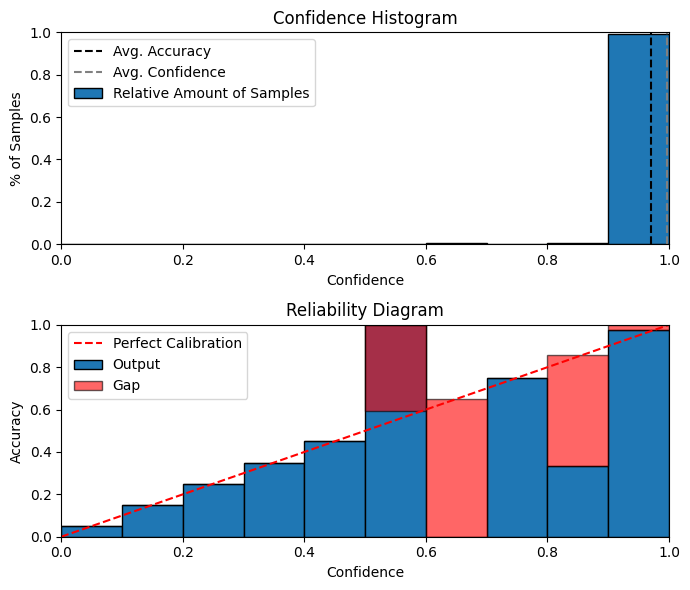

In [ ]:
compute_metrics(df_preds)

In [ ]:
print("Accracy: ", sum(df_preds["class_id"] == df_preds["predicted_class_id"])/len(df_preds))

Accracy:  0.9707943925233645


## Download model artifacts to local

In [ ]:
# # # Dowonload files to local
# from google.colab import files

# !zip -r models/all-MiniLM-L12-v2-tuned-v2.zip models/all-MiniLM-L12-v2-tuned-v2/

# files.download("models/all-MiniLM-L12-v2-tuned-v2.zip")